# Homework 7 - Stock and Google Search Correlation Analysis 2
## Group 1
## 20 July 2021

### Introduction

Code imports and performs analysis on daily stock price and interest over time using machine learning
* GameStop (GME) <br>
* Apple (AAPL) <br>
* Coke (KO)<br>
* John Deere (DE) <br>
* AMC (AMC) <br>


### Import

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import date
from pytrends.request import TrendReq

%matplotlib inline

### Global Varables

In [2]:
dataDir = r"./Data Files/"  #Directory of all data

today = date.today()  # Todays date

### Global Functions

In [3]:
# Function gets stock data and trend data if needed

def get_data(ticker):
    if os.path.exists(f"{dataDir}{ticker}_{today}.csv"):
        #Get stored data
        stored_data = pd.read_csv(f"{dataDir}{ticker}_{today}.csv")
        
        return stored_data
    else:
        #Get new data

        # Connect to Google API
        pytrends = TrendReq(hl='en-US', tz=360)

        # Set Keyword
        kw_list = [ticker]

        # Build Payload
        pytrends.build_payload(kw_list, timeframe='2021-04-01 2021-06-30', geo='')

        # Get trends Data frame
        trend_data = pytrends.interest_over_time()
        trend_data.rename(columns = {ticker: "Search Interest"},inplace = True)

        # Get Stock Data
        stock_data = yf.download(ticker, start="2021-04-01", end="2021-06-30", interval="1d")

        # Combine Data
        new_data = pd.concat([stock_data, trend_data], axis = 1, join = 'inner')

        # Export to data folder
        new_data.to_csv(f"{dataDir}{ticker}_{today}.csv")

        return new_data
    

### Data and Analysis

#### Gamestop(GME)
Connor Moore

##### Get Data

In [4]:
GME_DF = get_data("GME")

# Name unnamed date column
GME_DF.rename(columns = {"Unnamed: 0": "Date"},inplace = True)

GME_DF

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,193.360001,196.970001,183.600006,191.449997,191.449997,9334300,72,False
1,2021-04-05,171.000000,195.000000,164.809998,186.949997,186.949997,14070500,67,False
2,2021-04-06,185.210007,192.000000,183.559998,184.500000,184.500000,6218300,59,False
3,2021-04-07,183.220001,184.500000,176.110001,177.970001,177.970001,4768300,52,False
4,2021-04-08,185.880005,185.880005,164.300003,170.259995,170.259995,10047400,53,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,221.449997,222.570007,214.119995,219.339996,219.339996,3555100,43,False
58,2021-06-24,221.160004,227.449997,211.600006,212.309998,212.309998,3863300,36,False
59,2021-06-25,214.000000,214.199997,198.500000,209.509995,209.509995,12692700,33,False
60,2021-06-28,211.250000,224.449997,210.199997,213.250000,213.250000,4879400,33,False


In [5]:
# Add difference

GME_DF["Price Difference"] = GME_DF["Open"]-GME_DF["Close"]

In [6]:
# Set date as index
GME_DF.set_index('Date', inplace=True)
#add rename 
GME_DF.index = pd.to_datetime(GME_DF.index)
GME_DF

,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial,Price Difference
Date,,,,,,,,,
2021-04-01,193.360001,196.970001,183.600006,191.449997,191.449997,9334300,72,False,1.910004
2021-04-05,171.000000,195.000000,164.809998,186.949997,186.949997,14070500,67,False,-15.949997
2021-04-06,185.210007,192.000000,183.559998,184.500000,184.500000,6218300,59,False,0.710007
2021-04-07,183.220001,184.500000,176.110001,177.970001,177.970001,4768300,52,False,5.250000
2021-04-08,185.880005,185.880005,164.300003,170.259995,170.259995,10047400,53,False,15.620010
...,...,...,...,...,...,...,...,...,...
2021-06-23,221.449997,222.570007,214.119995,219.339996,219.339996,3555100,43,False,2.110001
2021-06-24,221.160004,227.449997,211.600006,212.309998,212.309998,3863300,36,False,8.850006
2021-06-25,214.000000,214.199997,198.500000,209.509995,209.509995,12692700,33,False,4.490005


##### Analysis 1

Text(0.5, 1.0, 'Price Difference vs. Search Interest - GME')

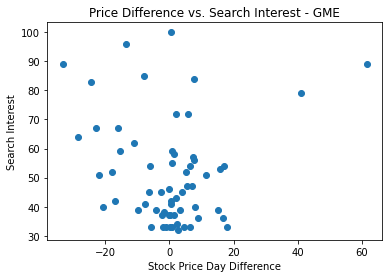

##### Analysis 2

Text(0.5, 1.0, 'Price Differnce and Interest Over Time - GME')

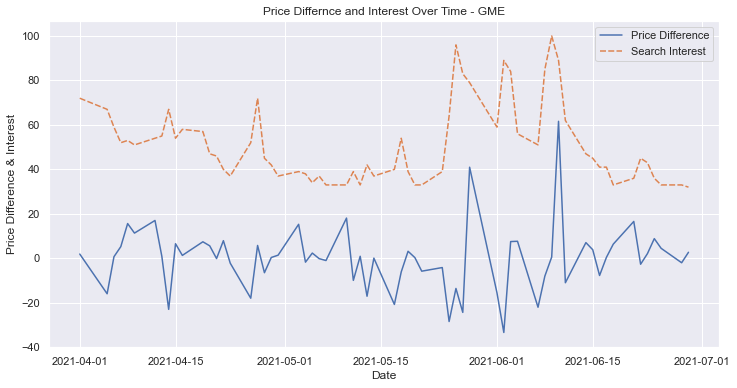

#### Apple (AAPL)
Ken Cupples

##### Get Data

In [10]:
#Reads in Apple stock data from a csv file
Apple = pd.read_csv(f"{dataDir}/AAPL.csv")

In [11]:
AppleSecondQuarter = get_data('aapl')
AppleSecondQuarter

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,123.660004,124.180000,122.489998,123.000000,122.791428,75089100,50,False
1,2021-04-05,123.870003,126.160004,123.070000,125.900002,125.686516,88651200,52,False
2,2021-04-06,126.500000,127.129997,125.650002,126.209999,125.995987,80171300,50,False
3,2021-04-07,125.830002,127.919998,125.139999,127.900002,127.683121,83466700,52,False
4,2021-04-08,128.949997,130.389999,128.520004,130.360001,130.138947,88844600,52,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,133.770004,134.320007,133.229996,133.699997,133.699997,60214200,35,False
58,2021-06-24,134.449997,134.639999,132.929993,133.410004,133.410004,68711000,38,False
59,2021-06-25,133.460007,133.889999,132.809998,133.110001,133.110001,70783700,31,False
60,2021-06-28,133.410004,135.250000,133.350006,134.779999,134.779999,62111300,30,False


In [12]:
# Name unnamed date column
AppleSecondQuarter.rename(columns = {"Unnamed: 0": "Date"},inplace = True)
AppleSecondQuarter

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,123.660004,124.180000,122.489998,123.000000,122.791428,75089100,50,False
1,2021-04-05,123.870003,126.160004,123.070000,125.900002,125.686516,88651200,52,False
2,2021-04-06,126.500000,127.129997,125.650002,126.209999,125.995987,80171300,50,False
3,2021-04-07,125.830002,127.919998,125.139999,127.900002,127.683121,83466700,52,False
4,2021-04-08,128.949997,130.389999,128.520004,130.360001,130.138947,88844600,52,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,133.770004,134.320007,133.229996,133.699997,133.699997,60214200,35,False
58,2021-06-24,134.449997,134.639999,132.929993,133.410004,133.410004,68711000,38,False
59,2021-06-25,133.460007,133.889999,132.809998,133.110001,133.110001,70783700,31,False
60,2021-06-28,133.410004,135.250000,133.350006,134.779999,134.779999,62111300,30,False


##### Analysis 1

##### Analysis 2

### Shawn Sonnack
AMC

#### Get Data

In [18]:
amcMergedDataFrame = get_data('AMC')



amcMergedDataFrame

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,10.230000,10.260000,9.150000,9.360000,9.360000,77473900,14,False
1,2021-04-05,10.100000,11.250000,9.720000,10.610000,10.610000,96082300,11,False
2,2021-04-06,10.400000,10.500000,10.000000,10.200000,10.200000,44067000,11,False
3,2021-04-07,10.070000,10.180000,9.850000,9.850000,9.850000,28804300,9,False
4,2021-04-08,10.010000,10.010000,9.500000,9.790000,9.790000,33408700,9,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,57.040001,61.099998,56.799999,58.299999,58.299999,116291800,23,False
58,2021-06-24,57.980000,58.759998,55.660000,56.700001,56.700001,80351200,24,False
59,2021-06-25,55.750000,56.290001,52.970001,54.060001,54.060001,77596900,26,False
60,2021-06-28,55.099998,59.360001,54.330002,58.110001,58.110001,99310200,27,False


In [19]:
# Add a Column Representing Amount Lost or Gained
amcMergedDataFrame["Amount Changed"] = amcMergedDataFrame["Open"] - amcMergedDataFrame["Close"]
amcMergedDataFrame

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial,Amount Changed
0,2021-04-01,10.230000,10.260000,9.150000,9.360000,9.360000,77473900,14,False,0.870000
1,2021-04-05,10.100000,11.250000,9.720000,10.610000,10.610000,96082300,11,False,-0.509999
2,2021-04-06,10.400000,10.500000,10.000000,10.200000,10.200000,44067000,11,False,0.200000
3,2021-04-07,10.070000,10.180000,9.850000,9.850000,9.850000,28804300,9,False,0.219999
4,2021-04-08,10.010000,10.010000,9.500000,9.790000,9.790000,33408700,9,False,0.220000
...,...,...,...,...,...,...,...,...,...,...
57,2021-06-23,57.040001,61.099998,56.799999,58.299999,58.299999,116291800,23,False,-1.259998
58,2021-06-24,57.980000,58.759998,55.660000,56.700001,56.700001,80351200,24,False,1.279999
59,2021-06-25,55.750000,56.290001,52.970001,54.060001,54.060001,77596900,26,False,1.689999
60,2021-06-28,55.099998,59.360001,54.330002,58.110001,58.110001,99310200,27,False,-3.010002


##### Analysis 1

##### Analysis 2

In [ ]:



### Coke
Arielle Swift

#### Get Data

In [27]:
KO2ndQtrData = get_data("KO")

# Name unnamed date column
KO2ndQtrData.rename(columns = {"Unnamed: 0": "Date"},inplace = True)

KO2ndQtrData

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,52.959999,53.150002,52.459999,52.509998,52.117294,15834700,84,False
1,2021-04-05,52.349998,53.220001,52.290001,52.810001,52.415054,16368700,84,False
2,2021-04-06,53.040001,53.650002,52.900002,53.189999,52.792210,15614300,79,False
3,2021-04-07,53.279999,53.500000,53.119999,53.279999,52.881535,10062700,78,False
4,2021-04-08,53.169998,53.380001,52.970001,53.119999,52.722733,9695600,82,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,54.560001,54.599998,54.110001,54.119999,54.119999,12339200,82,False
58,2021-06-24,54.259998,54.419998,54.000000,54.389999,54.389999,11488400,83,False
59,2021-06-25,54.240002,54.470001,54.009998,54.320000,54.320000,18880300,87,False
60,2021-06-28,54.250000,54.369999,54.000000,54.259998,54.259998,10556900,83,False


In [28]:
KO2ndQtrData['Date']= pd.to_datetime(KO2ndQtrData['Date'],format='%Y-%m-%d')
KO2ndQtrData['Date'] = KO2ndQtrData['Date'].dt.strftime('%m-%d-%Y')
KO2ndQtrData


,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,04-01-2021,52.959999,53.150002,52.459999,52.509998,52.117294,15834700,84,False
1,04-05-2021,52.349998,53.220001,52.290001,52.810001,52.415054,16368700,84,False
2,04-06-2021,53.040001,53.650002,52.900002,53.189999,52.792210,15614300,79,False
3,04-07-2021,53.279999,53.500000,53.119999,53.279999,52.881535,10062700,78,False
4,04-08-2021,53.169998,53.380001,52.970001,53.119999,52.722733,9695600,82,False
...,...,...,...,...,...,...,...,...,...
57,06-23-2021,54.560001,54.599998,54.110001,54.119999,54.119999,12339200,82,False
58,06-24-2021,54.259998,54.419998,54.000000,54.389999,54.389999,11488400,83,False
59,06-25-2021,54.240002,54.470001,54.009998,54.320000,54.320000,18880300,87,False
60,06-28-2021,54.250000,54.369999,54.000000,54.259998,54.259998,10556900,83,False


In [29]:
KO2ndQtrData = KO2ndQtrData.loc[(KO2ndQtrData['Date'] >= '04-01-2021')
                     & (KO2ndQtrData['Date'] < '07-01-2021')]

##### Analysis 1

##### Analysis 2

### Tesla (TSLA)
Andrew T.

Next few lines are about extracting Google Trends data the word Tesla over 04-01-2021 to 06-30-2021 time period as well as the financial information of the Tesla stock.  You are able to see the open and closing price along with the high and lows for the day and the trading volume.

In [ ]:
tesladf = get_data("TSLA")

# Name unnamed date column
tesladf.rename(columns = {"Unnamed: 0": "Date"},inplace = True)

# Set date as index
tesladf.set_index('Date', inplace=True)

tesladf

The mean Search Interest for Tesla is 67.1 over the time period of 04-01-2021 to 06-30-2021. For a given day the search interest is subracted from the mean and is added to the teslaTrendsdf Data Frame in a new column.

In [ ]:
teslaTrendsMean = tesladf['Search Interest'].mean()
#print(f'The mean of the Search Interest for Tesla is {teslaTrendsMean}')
tesladf["Points Away From Mean"] = tesladf["Search Interest"] - teslaTrendsMean
tesladf



##### Analysis 1

##### Analysis 2

### John Deere (DE)
Dan Knobloch

#### Data Load:

In [42]:
JDStockTrend = get_data("DE")

# Name unnamed date column
JDStockTrend.rename(columns = {"Unnamed: 0": "Date"},inplace = True)

JDStockTrend

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,isPartial
0,2021-04-01,375.630005,376.000000,369.290009,372.119995,371.162811,1561900,85,False
1,2021-04-05,375.600006,377.940002,373.910004,374.809998,373.845886,1419500,91,False
2,2021-04-06,375.790009,381.839996,375.019989,375.609985,374.643829,1309700,94,False
3,2021-04-07,375.750000,378.880005,372.410004,374.790009,373.825958,1299300,94,False
4,2021-04-08,372.290009,374.529999,368.630005,374.070007,373.107819,1250700,92,False
...,...,...,...,...,...,...,...,...,...
57,2021-06-23,342.679993,349.170013,341.489990,347.750000,346.855499,3352700,91,False
58,2021-06-24,349.559998,354.739990,346.529999,350.619995,349.718109,2140200,92,False
59,2021-06-25,354.089996,355.890015,347.140015,349.989990,349.089722,6604800,91,False
60,2021-06-28,350.380005,350.950012,345.100006,349.890015,348.990021,1304200,92,False


##### Analysis 1

##### Analysis 2